# Projekat: Ball and Beam

U projektu je opisana upotreba Q-Learning i SARSA algoritama za problem balansiranja loptice na gredi (Ball and Beam). Za detaljno objašnjenje problema pogledati sledeći dokument: "Dokumentacija SOAA.pdf".

U nastavku će biti urađeni zadaci koji su opisani u sekciji 4 u istoimenom dokumentu.

Postupak rada na projektu:
1. Izvršiti diskretizaciju matematičkog modela u prostoru stanja.
2. Definisanje prostora akcija i stanja, s tim da je prostor akcija diskretan.
3. Implementacija načina dodele nagrade.
4. Treniranje agenta primenom Q-Learning i SARSA algoritma uz eksperimentisanje sa različitim vrednostima hiperparametra datih algoritama.
5. Prikaz dobijenih rezultata.
6. Kreiranje pomoćnog alata koji će se koristiti za vizualizaciju.

## Potrebne biblioteke

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Okruženje

Okruženje predstavlja sam matematički model problema koji je preveden u MPO što obuhvata:
- Inicijalizaciju početnih vrednosti svih polja od značaja, u šta spadaju: 
    - fizičke veličine koje su pobrojane u opisu problema, 
    - defnicija koncepta stanja, 
    - promenljive potrebne za *Euler 1* diskretizaciju, 
    - granične vrednosti za vrednosti stanja, 
    - ograničenje trajanja epizoda i 
    - skup akcija.
- Formula koja opisuje sam problem.
- Način koji je opisan u dokumentu koji se koristi za formiranje nagrade upotrebom DRM (Detail-Reward Mechanism) principa koji se oslanja na proizvod evaluacionih funkcija.
- Funkcija koja se koristi za izvršavanje akcije i menja stanje.
- Reset samog okruženja koji se koristi za potrebe pokretanja novih epizoda.
- Konačno i formiranje samog okruženja kao objekta.

In [74]:
class Enviroment():
    # m - masa loptice (0.1113 kg je preporucena vrednost)
    # r - poluprecnik loptice (0.015 m je preporucena vrednost)
    # l - duzina grede (0.4 m je preporucena vrednost)
    # TIME_STEP - za diskretizaciju vremena (0.05 s je preporucena vrednost)
    # J - moment inercije za lopticu (J = 2/5 * m * r ^ 2)
    # alpha - ugao rotacije (ugao u radijanima)
    # g - gravitaciona konstanta (9.81 m/s^2 je preporucena vrednost)
    # kf - koeficijent trenja (0.5 je preporucena vrednost uz pretpostavku da je metalna loptica i drvena greda)
    # p - koeficijent kaznjavanja (1 je preporucena vrednost)
    def __init__(self, m: float = 0.113, r: float = 0.015, l: float = 0.4, g: float = 9.81, kf: float = 0.5, TIME_STEP: float = 0.05):
        self.m = m
        self.r = r
        self.l = l
        self.J = 0.4 * m * r ** 2
        self.g = g
        self.kf = kf
        self.TIME_STEP = TIME_STEP
        self.p = 1

        # Loptica se nalazi na sredini grede na pocetku i greda je u ravnoteznom polozaju
        # Ovo je u sustini stanje z = (z1, z2, z3, z4)
        self.x = 0
        self.x_dot = 0
        self.alpha = 0
        self.alpha_dot = 0

        # Ogranicenja maksimalnih vrednosti
        self.x_dot_max = 0.5
        self.alpha_max = 0.35
        self.alpha_dot_max = 1
        
        # Ako predjemo 500 koraka vraca se true za truncated (ogranicavamo duzinu epizode)
        self.steps = 0
        self.max_steps = 500
        self.trunc = False
        # Da li je loptica pala?
        self.term = False

        # Ugaono ubrzanje predstavlja akciju (rad/s^2)
        # Skup akcija
        self.actions = [-5, -2.5, 0, 2.5, 5]

    # Naredna funkcija je formula sa pdf-a
    def x_ddot(self):
        return - self.x_dot * (self.kf * self.r ** 2) / (self.m * self.r ** 2 + self.J) + np.sin(self.alpha) * (self.m * self.g * self.r ** 2) / (self.m * self.r ** 2 + self.J)

    # Funkcija nagrade dobijena primenom DRM bazirana na evaluacionim funkcijama
    def reward(self):
        reward = self.e_0() * self.e_1() * self.e_2()
        return reward
    
    # Evaluacione funkcije, date su u pdf-u
    def e_0(self):
        if self.x > self.l / 2 or self.x < - self.l / 2:
            return 0
        if self.x_dot > self.x_dot_max or self.x_dot < - self.x_dot_max:
            return 0
        if self.alpha > self.alpha_max or self.alpha < - self.alpha_max:
            return 0
        if self.alpha_dot > self.alpha_dot_max or self.alpha_dot < - self.alpha_dot_max:
            return 0
        return 1

    def e_1(self):
        return 1 - 2 * abs(self.x) / self.l

    def e_2(self):
        return max(0, 1 - self.p * abs(self.x_ddot()))

    # alpha_ddot - akcija (ugaono ubrzanje) koje primenjujemo
    # action - akcija koju uzimamo
    # action predstavlja indeks unutar actions tako da indeksi [0,1,2,3,4] odgovaraju akcijama [-5, -2.5, 0, 2.5, 5]
    def take_action(self, action: int):
        self.steps += 1
        if self.steps > self.max_steps:
            self.trunc = True   # Znaci nije terminalno stanje (pad sipke), vec smo prosto dosli do kraja epizode
            self.term = False
            return [self.x, self.x_dot, self.alpha, self.alpha_dot], self.reward(), self.trunc, self.term

        # U slucaju da je loptica pala sa grede
        if self.x > self.l / 2 or self.x < - self.l / 2:
            self.term = True
            return [self.x, self.x_dot, self.alpha, self.alpha_dot], self.reward(), self.trunc, self.term
        
        # Primenom akcije menja se stanje
        alpha_ddot = self.actions[action]
        # Stanje je z = (z1, z2, z3, z4) pa je promena stanja definisana u naredne 4 linije
        self.x = self.x + self.TIME_STEP * self.x_dot
        self.x_dot = self.x_dot + self.TIME_STEP * self.x_ddot()
        self.alpha = self.alpha + self.TIME_STEP * self.alpha_dot
        self.alpha_dot = self.alpha_dot + self.TIME_STEP * alpha_ddot

        return [self.x, self.x_dot, self.alpha, self.alpha_dot], self.reward(), self.trunc, self.term

    #Reset okruzenja kako bi se mogla odigrati nova epizoda, resetuje se stanje, kako se epizoda zavrsila i korak u epizodi 
    def reset(self):
        self.x = 0
        self.x_dot = 0
        self.alpha = 0
        self.alpha_dot = 0
        self.steps = 0
        self.trunc = False
        self.term = False
        return [self.x, self.x_dot, self.alpha, self.alpha_dot], self.reward(), self.trunc, self.term

In [75]:
env = Enviroment(m = 0.113, r = 0.015, l = 0.4, g = 9.81, kf = 0.5, TIME_STEP = 0.05)

## Diskretizacija

In [76]:
# Broj binova za svaku dimenziju stanja
N_X_BINS = 20
N_X_DOT_BINS = 20
N_ALPHA_BINS = 20
N_ALPHA_DOT_BINS = 20

# Granice za diskretizaciju
# Stavljao sam isto ogranicenje kao da su thresholdi, koji su definisani u e0 u pdf fajlu :)

# Ove promenljive su dodate kako bi se lakse menjale njihove vrednosti ako treba :)
x_th = 0.2
x_dot_th = 0.5
alpha_th = 0.35
alpha_dot_th = 1

# Granice za poziciju
x_bins = np.linspace(-x_th, x_th, N_X_BINS + 1)
# Granice brzina - namesteno da se sistem ponasa "realno"
x_dot_bins = np.linspace(-x_dot_th, x_dot_th, N_X_DOT_BINS + 1)
# Granice za ugao u radijanima
alpha_bins = np.linspace(-alpha_th, alpha_th, N_ALPHA_BINS + 1)  
# Granice za ugaonu brzinu moraju biti male kako bi sistem bio stabilan
alpha_dot_bins = np.linspace(-alpha_dot_th, alpha_dot_th, N_ALPHA_DOT_BINS + 1)

# Funkcija za konverziju kontinualnog stanja u diskretni indeks
def discretize_state(state):
    x, x_dot, alpha, alpha_dot = state
    
    # clip sprecava pojavu ekstremnih vrednosti tako sto neki autsajder postave na njemu najblizu granicu
    x = np.clip(x, -x_th, x_th)
    x_dot = np.clip(x_dot, -x_dot_th, x_dot_th)
    alpha = np.clip(alpha, -alpha_th, alpha_th)
    alpha_dot = np.clip(alpha_dot, -alpha_dot_th, alpha_dot_th)
    
    # digitize - vraca vrednost bina u koji spada vrednost
    x_idx = np.digitize(x, x_bins) - 1
    x_dot_idx = np.digitize(x_dot, x_dot_bins) - 1
    theta_idx = np.digitize(alpha, alpha_bins) - 1
    theta_dot_idx = np.digitize(alpha_dot, alpha_dot_bins) - 1
    
    # clamp - osigurava da indeks nikad ne izadje van validnog opsega
    x_idx = max(0, min(x_idx, N_X_BINS - 1))
    x_dot_idx = max(0, min(x_dot_idx, N_X_DOT_BINS - 1))
    alpha_idx = max(0, min(theta_idx, N_ALPHA_BINS - 1))
    alpha_dot_idx = max(0, min(theta_dot_idx, N_ALPHA_DOT_BINS - 1))
    
    return (x_idx, x_dot_idx, alpha_idx, alpha_dot_idx)

## Treniranje agenata 

U narednim ćelijama će biti prikazane sledeće stvari:
- pomoćne funkcije koje se koriste za vizualizaciju procesa treniranja i to redom za Q-Learning agenta, za SARSA agenta i uporedn vizualizacija za oba agenta,
- epsilon-greedy politika odlučivanja koja se koristi za donošenje odluka,
- postupak treniranja Q-Learning i SARSA agenata i
- izvoz dobijenih Q tabela.

### Vizualizacija treniranja

In [84]:
# Vizualizacija Q-Learning-a

def visualize_q_learning(rewards_per_episode, steps_per_episode, EPISODES, EPSILON, EPSILON_DECAY, EPSILON_MIN):
    plt.figure(figsize=(15, 10))
    plt.suptitle("Q-Learning Vizualizacija")

    # 1. Raw rewards
    plt.subplot(2, 3, 1)
    plt.plot(rewards_per_episode, alpha=0.3, color='blue')
    plt.xlabel('Epizoda')
    plt.ylabel('Ukupna nagrada')
    plt.title('Nagrade tokom treniranja (raw)')

    # 2. Raw steps
    plt.subplot(2, 3, 2)
    plt.plot(steps_per_episode, alpha=0.3, color='green')
    plt.xlabel('Epizoda')
    plt.ylabel('Broj koraka')
    plt.title('Broj koraka po epizodi (raw)')

    # 3. Epsilon decay
    plt.subplot(2, 3, 3)
    epsilons = [EPSILON - i * EPSILON_DECAY if 1 - i * EPSILON_DECAY > EPSILON_MIN else EPSILON_MIN for i in range(EPISODES)]
    plt.plot(epsilons, color='red')
    plt.xlabel('Epizoda')
    plt.ylabel('Epsilon')
    plt.title('Epsilon decay tokom treniranja')

    # 4. Moving average nagrade - prikazuje konvergenciju
    plt.subplot(2, 3, 4)
    window = 100
    moving_avg_rewards = np.convolve(
        rewards_per_episode,
        np.ones(window)/window,
        mode='valid'
    )
    plt.plot(moving_avg_rewards, color='blue', linewidth=2)
    plt.xlabel('Epizoda')
    plt.ylabel('Prosečna nagrada')
    plt.title(f'Pokretni prosek nagrade ({window} epizoda)')

    # 5. Moving average koraka - prikazuje konvergenciju
    plt.subplot(2, 3, 5)
    moving_avg_steps = np.convolve(
        steps_per_episode,
        np.ones(window)/window,
        mode='valid'
    )
    plt.plot(moving_avg_steps, color='green', linewidth=2)
    plt.xlabel('Epizoda')
    plt.ylabel('Prosečan broj koraka')
    plt.title(f'Pokretni prosek koraka ({window} epizoda)')

    # 6. Poslednje epizode (zoom)
    plt.subplot(2, 3, 6)
    last_n = 1000
    plt.plot(rewards_per_episode[-last_n:], alpha=0.5)
    plt.xlabel('Epizoda')
    plt.ylabel('Nagrada')
    plt.title(f'Poslednjih {last_n} epizoda (detalj)')

    plt.tight_layout()
    plt.show()

In [100]:
# Vizualizacija SARSA

def visualize_sarsa(rewards_per_episode_S, steps_per_episode_S, EPISODES_S, EPSILON_S, EPSILON_DECAY_S, EPSILON_MIN_S):
    plt.figure(figsize=(15, 10))
    plt.suptitle("SARSA Vizualizacija")

    # 1. Raw rewards
    plt.subplot(2, 3, 1)
    plt.plot(rewards_per_episode_S, alpha=0.3, color='orange')
    plt.xlabel('Epizoda')
    plt.ylabel('Ukupna nagrada')
    plt.title('Nagrade tokom treniranja (raw)')

    # 2. Raw steps
    plt.subplot(2, 3, 2)
    plt.plot(steps_per_episode_S, alpha=0.3, color='purple')
    plt.xlabel('Epizoda')
    plt.ylabel('Broj koraka')
    plt.title('Broj koraka po epizodi (raw)')

    # 3. Epsilon decay
    plt.subplot(2, 3, 3)
    epsilons_S = [EPSILON_S - i * EPSILON_DECAY_S if 1 - i * EPSILON_DECAY_S > EPSILON_MIN_S else EPSILON_MIN_S for i in range(EPISODES_S)]
    plt.plot(epsilons_S, color='red')
    plt.xlabel('Epizoda')
    plt.ylabel('Epsilon')
    plt.title('Epsilon decay tokom treniranja')

    # 4. Moving average nagrade
    plt.subplot(2, 3, 4)
    window = 100
    moving_avg_rewards_S = np.convolve(
        rewards_per_episode_S,
        np.ones(window) / window,
        mode='valid'
    )
    plt.plot(moving_avg_rewards_S, color='orange', linewidth=2)
    plt.xlabel('Epizoda')
    plt.ylabel('Prosečna nagrada')
    plt.title(f'Pokretni prosek nagrade ({window} epizoda)')

    # 5. Moving average koraka
    plt.subplot(2, 3, 5)
    moving_avg_steps_S = np.convolve(
        steps_per_episode_S,
        np.ones(window) / window,
        mode='valid'
    )
    plt.plot(moving_avg_steps_S, color='purple', linewidth=2)
    plt.xlabel('Epizoda')
    plt.ylabel('Prosečan broj koraka')
    plt.title(f'Pokretni prosek koraka ({window} epizoda)')

    # 6. Poslednje epizode (zoom)
    plt.subplot(2, 3, 6)
    last_n = 1000
    plt.plot(rewards_per_episode_S[-last_n:], alpha=0.5, color='orange')
    plt.xlabel('Epizoda')
    plt.ylabel('Nagrada')
    plt.title(f'Poslednjih {last_n} epizoda (detalj)')

    plt.tight_layout()
    plt.show()

In [79]:
# Uporedna vizualizacija Q-Learning vs SARSA

def visualize_comparison(rewards_per_episode, rewards_per_episode_S, steps_per_episode, steps_per_episode_S):
    window = 100
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Q-Learning vs SARSA — poređenje', fontsize=14, fontweight='bold')

    def moving_avg(data):
        return np.convolve(data, np.ones(window) / window, mode='valid')

    # Nagrade
    ax = axes[0]
    ax.plot(moving_avg(rewards_per_episode), color='blue', linewidth=2, label='Q-Learning')
    ax.plot(moving_avg(rewards_per_episode_S), color='orange', linewidth=2, label='SARSA')
    ax.set_xlabel('Epizoda')
    ax.set_ylabel('Prosečna nagrada')
    ax.set_title(f'Pokretni prosek nagrade ({window} epizoda)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Koraci
    ax = axes[1]
    ax.plot(moving_avg(steps_per_episode), color='green', linewidth=2, label='Q-Learning')
    ax.plot(moving_avg(steps_per_episode_S), color='purple', linewidth=2, label='SARSA')
    ax.set_xlabel('Epizoda')
    ax.set_ylabel('Prosečan broj koraka')
    ax.set_title(f'Pokretni prosek koraka ({window} epizoda)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Politika odlučivanja

In [80]:
# Politika koju koristimo u oba algoritma

random.seed(17 + 13)

def eps_greedy(q, eps: float):
    if random.random() > eps:
        return np.argmax(q)
    else:                                   
        return random.randint(0, 4)          # 0-4 jer imam 5 akcija i zelim da svaka moze biti odabrana

### Q-Learning agent

Ovaj agent je nastao za potrebe funkcionalnog testiranja i kasnije za upotrebu u aplikaciji.

In [92]:
# Agent
ALPHA_Q = 0.1      # learning rate - koliko brzo agent uci iz novih iskustava
GAMMA_Q = 0.99     # discount factor - govori koliko agent ceni buduce nagrade
                    
Q = np.zeros((N_X_BINS, N_X_DOT_BINS, N_ALPHA_BINS, N_ALPHA_DOT_BINS, 5))   # 5 jer imamo 5 akcija [-5, -2.5, 0, 2.5, 5]

# epsilon sa decay stopom jer zelimo prvo eksloraciju a potom eksploataciju
EPSILON = 1
eps_decay_rate = 0.000005 
EPISODES = 250000
EPSILON_MIN = 0.001

# za pracenje napretka
rewards_per_episode = []
steps_per_episode = []

# Trening petlja
for episode in range(EPISODES):
    EPSILON = max(EPSILON_MIN, EPSILON - eps_decay_rate)

    # Resetujem okruzenje
    state, _, _, _ = env.reset()
    state[0] = env.x         = np.clip(np.random.normal(0, x_th / 4), -0.19, 0.19)
    state[1] = env.x_dot     = np.clip(np.random.normal(0, x_dot_th / 4), -0.49, 0.49)
    state[2] = env.alpha     = np.clip(np.random.normal(0, alpha_th / 4), -0.34, 0.34)
    state[3] = env.alpha_dot = np.clip(np.random.normal(0, alpha_dot_th / 4), -0.99, 0.99)

    state_idx = discretize_state(state)
    total_reward = 0
    done = False

    # epizoda
    while not done:
        action = eps_greedy(Q[state_idx], EPSILON)
        next_state, reward, truncated, terminated = env.take_action(action)
        next_state_idx = discretize_state(next_state)

        # Q-Learning update formula
        # Q(s,a) = Q(s,a) + α * [r + γ * max(Q(s',a')) - Q(s,a)] 
        Q[state_idx][action] += ALPHA_Q*(reward + GAMMA_Q*np.max(Q[next_state_idx]) - Q[state_idx][action] ) 

        # predji na sledece stanje
        state_idx = next_state_idx
        total_reward += reward

        # provera da li je epizoda zavrsena
        done = terminated or truncated
        
    # cuvam rezultate epizode
    rewards_per_episode.append(total_reward)
    steps_per_episode.append(env.steps)

    # na svakih 10000 epizoda zelim da ispisem napredak
    if(episode + 1) % 10000 == 0:
        avg_reward = np.mean(rewards_per_episode[-10000 :])
        avg_steps = np.mean(steps_per_episode[-10000 :])
        print(f"Epizoda {episode+1}/{EPISODES}, Prosecna nagrada>> {avg_reward:.2f}, Prosecan broj koraka>> {avg_steps:.2f}, Epsilon>>{EPSILON:.2f}")


Epizoda 10000/250000, Prosecna nagrada>> 6.83, Prosecan broj koraka>> 25.26, Epsilon>>0.95
Epizoda 20000/250000, Prosecna nagrada>> 7.15, Prosecan broj koraka>> 25.74, Epsilon>>0.90
Epizoda 30000/250000, Prosecna nagrada>> 7.93, Prosecan broj koraka>> 26.96, Epsilon>>0.85
Epizoda 40000/250000, Prosecna nagrada>> 8.77, Prosecan broj koraka>> 28.23, Epsilon>>0.80
Epizoda 50000/250000, Prosecna nagrada>> 9.76, Prosecan broj koraka>> 29.75, Epsilon>>0.75
Epizoda 60000/250000, Prosecna nagrada>> 11.31, Prosecan broj koraka>> 31.91, Epsilon>>0.70
Epizoda 70000/250000, Prosecna nagrada>> 13.53, Prosecan broj koraka>> 35.27, Epsilon>>0.65
Epizoda 80000/250000, Prosecna nagrada>> 16.10, Prosecan broj koraka>> 39.37, Epsilon>>0.60
Epizoda 90000/250000, Prosecna nagrada>> 20.75, Prosecan broj koraka>> 46.18, Epsilon>>0.55
Epizoda 100000/250000, Prosecna nagrada>> 29.87, Prosecan broj koraka>> 59.67, Epsilon>>0.50
Epizoda 110000/250000, Prosecna nagrada>> 46.43, Prosecan broj koraka>> 82.76, Epsil

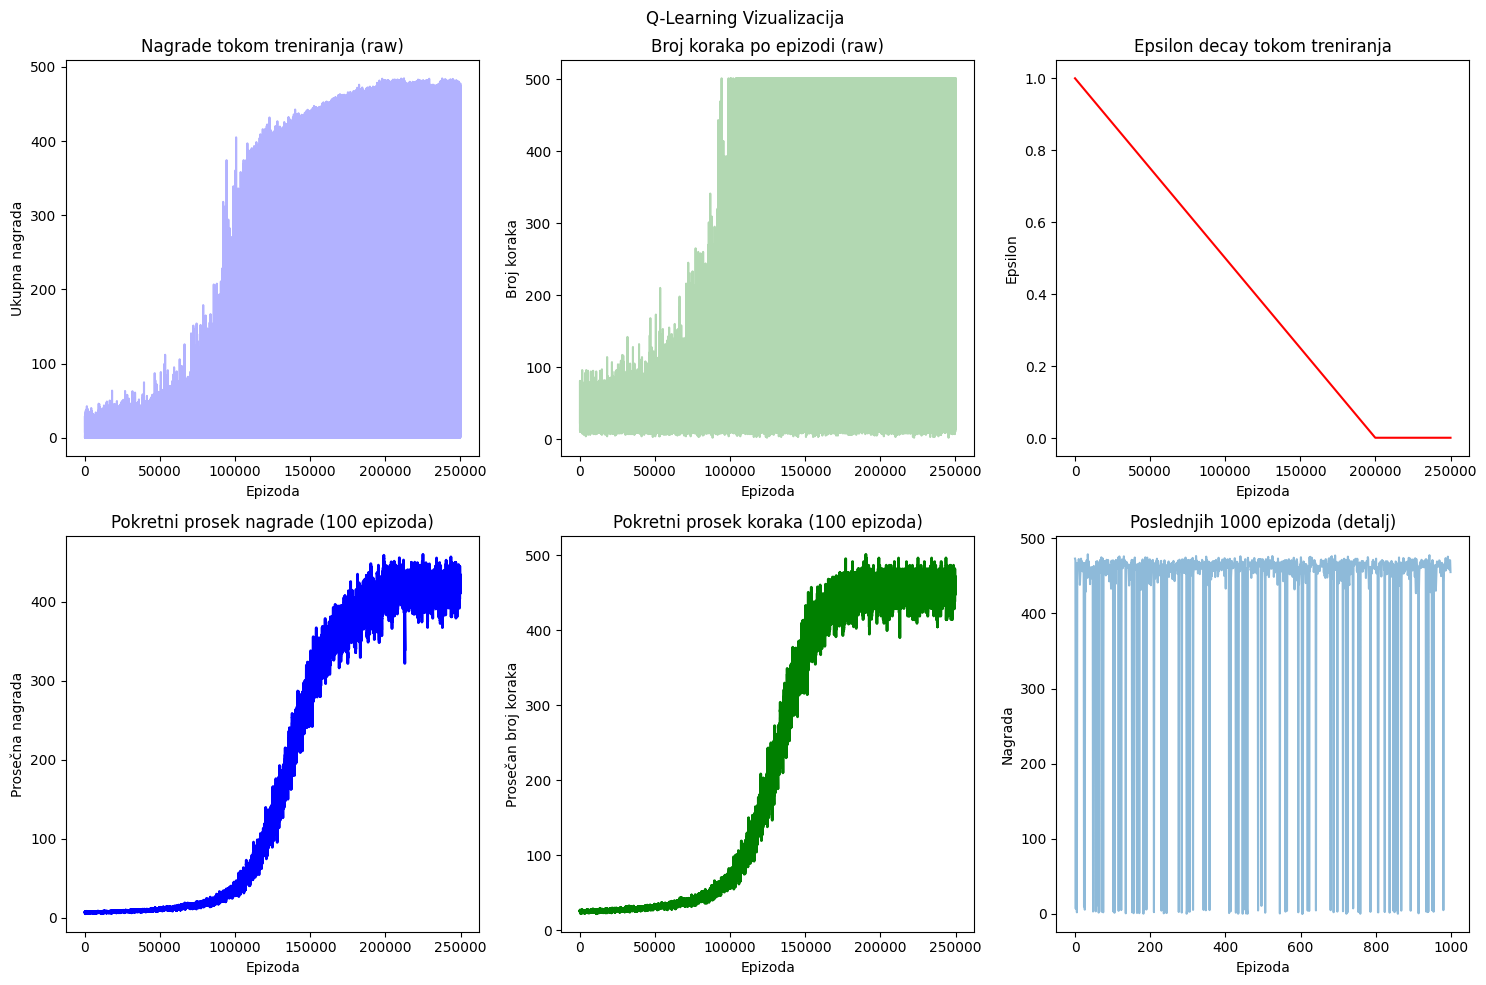

In [98]:
visualize_q_learning(rewards_per_episode, steps_per_episode, EPISODES, 1, eps_decay_rate, EPSILON_MIN)

### Q-LEARNING analiza grafika
Agent u početku istražuje, zatim pronalazi bolju strategiju i prelazi u eksploataciju. Kriva ima sigmoidni oblik učenja koji je tipičan za učenje potkrepljenjem – spor početak, brzi rast, stabilizacija.

Veći broj koraka je povezan sa boljom kontrolm i dužim preživljavanjem. Pošto se broj koraka stabilizuje na maksimumu možemo reći da je agent konvergirao ka skoro optimalnoj politici u datom diskretizovanom prostoru stanja.

Učenje je skočilo baš dok je epsilon bilo između 0.6 i 0.2, dakle u fazi kad je agent imao dovoljno eksploatacije da iskoristi naučeno, ali i još malo eksploracije. Linearni decay može biti previše nagao jer jednako brzo smanjuje eksploraciju kroz celu fazu treniranja. Eksponencijalni decay bi omogućio brže smanjenje u početku, ali sporije približavanje minimumu, što bi dalo stabilniji prelaz iz eksploracije u eksploataciju.

Što se tiče pokretnog proseka nagrade i broja koraka krive su glatke bez mnogo oscilacija. Deluje da je učenje stabilno i da agent postiže skoro maksimalan učinak.

U poslednjih 1000 epizoda možemo da primetimo da je većina epizoda blizu maksimuma (~450–480), ali postoje periodični veliki padovi (≈ 0). To ukazuje da politika nije potpuno robusna i da postoje retke situacije u kojima agent donosi suboptimalnu odluku.


### SARSA agent

Ovaj agent je nastao za potrebe funkcionalnog testiranja i kasnije za upotrebu u aplikaciji.

In [102]:
# Agent
ALPHA_S = 0.1
GAMMA_S = 0.99

Q_S = np.zeros((N_X_BINS, N_X_DOT_BINS, N_ALPHA_BINS, N_ALPHA_DOT_BINS, 5))

EPSILON_S = 1
eps_decay_rate_S = 0.000005
EPISODES_S = 250000
EPS_MIN_S = 0.001

rewards_per_episode_S = []
steps_per_episode_S = []

for episode in range(EPISODES_S):
    EPSILON_S = max(EPS_MIN_S, EPSILON_S - eps_decay_rate_S)

    state, _, _, _ = env.reset()
    state[0] = env.x         = np.clip(np.random.normal(0, x_th / 4), -0.19, 0.19)
    state[1] = env.x_dot     = np.clip(np.random.normal(0, x_dot_th / 4), -0.49, 0.49)
    state[2] = env.alpha     = np.clip(np.random.normal(0, alpha_th / 4), -0.34, 0.34)
    state[3] = env.alpha_dot = np.clip(np.random.normal(0, alpha_dot_th / 4), -0.99, 0.99)
    
    state_idx = discretize_state(state)
    
    # SARSA: akcija se bira NA POCETKU epizode, pre petlje
    action = eps_greedy(Q_S[state_idx], EPSILON_S)
    
    total_reward = 0
    done = False

    while not done:
        next_state, reward, truncated, terminated = env.take_action(action)
        next_state_idx = discretize_state(next_state)

        # SARSA: sledeca akcija se bira epsilon-greedy (ne max!)
        next_action = eps_greedy(Q_S[next_state_idx], EPSILON_S)

        # SARSA update formula:
        # Q(s,a) = Q(s,a) + α * [r + γ * Q(s', a') - Q(s,a)]
        # Razlika vs Q-Learning: koristimo Q(s', a') gde je a' vec odabrana,
        # a ne max_a'(Q(s', a')) — zato je SARSA on-policy
        Q_S[state_idx][action] += ALPHA_S * ( reward + GAMMA_S * Q_S[next_state_idx][next_action] - Q_S[state_idx][action])

        # Prenosimo odabranu akciju u sledeci korak (kljucna razlika u odnosu na Q-Learning)
        state_idx = next_state_idx
        action = next_action
        total_reward += reward

        done = terminated or truncated

    rewards_per_episode_S.append(total_reward)
    steps_per_episode_S.append(env.steps)

    if (episode + 1) % 10000 == 0:
        avg_reward = np.mean(rewards_per_episode_S[-10000:])
        avg_steps = np.mean(steps_per_episode_S[-10000:])
        print(f"Epizoda {episode+1}/{EPISODES_S}, Prosecna nagrada>> {avg_reward:.2f}, Prosecan broj koraka>> {avg_steps:.2f}, Epsilon>> {EPSILON_S:.2f}")

Epizoda 10000/250000, Prosecna nagrada>> 6.64, Prosecan broj koraka>> 25.00, Epsilon>> 0.95
Epizoda 20000/250000, Prosecna nagrada>> 6.98, Prosecan broj koraka>> 25.41, Epsilon>> 0.90
Epizoda 30000/250000, Prosecna nagrada>> 7.60, Prosecan broj koraka>> 26.35, Epsilon>> 0.85
Epizoda 40000/250000, Prosecna nagrada>> 8.51, Prosecan broj koraka>> 27.68, Epsilon>> 0.80
Epizoda 50000/250000, Prosecna nagrada>> 9.56, Prosecan broj koraka>> 29.29, Epsilon>> 0.75
Epizoda 60000/250000, Prosecna nagrada>> 10.83, Prosecan broj koraka>> 31.18, Epsilon>> 0.70
Epizoda 70000/250000, Prosecna nagrada>> 12.38, Prosecan broj koraka>> 33.50, Epsilon>> 0.65
Epizoda 80000/250000, Prosecna nagrada>> 14.13, Prosecan broj koraka>> 36.36, Epsilon>> 0.60
Epizoda 90000/250000, Prosecna nagrada>> 16.54, Prosecan broj koraka>> 40.00, Epsilon>> 0.55
Epizoda 100000/250000, Prosecna nagrada>> 20.12, Prosecan broj koraka>> 45.56, Epsilon>> 0.50
Epizoda 110000/250000, Prosecna nagrada>> 26.26, Prosecan broj koraka>> 54

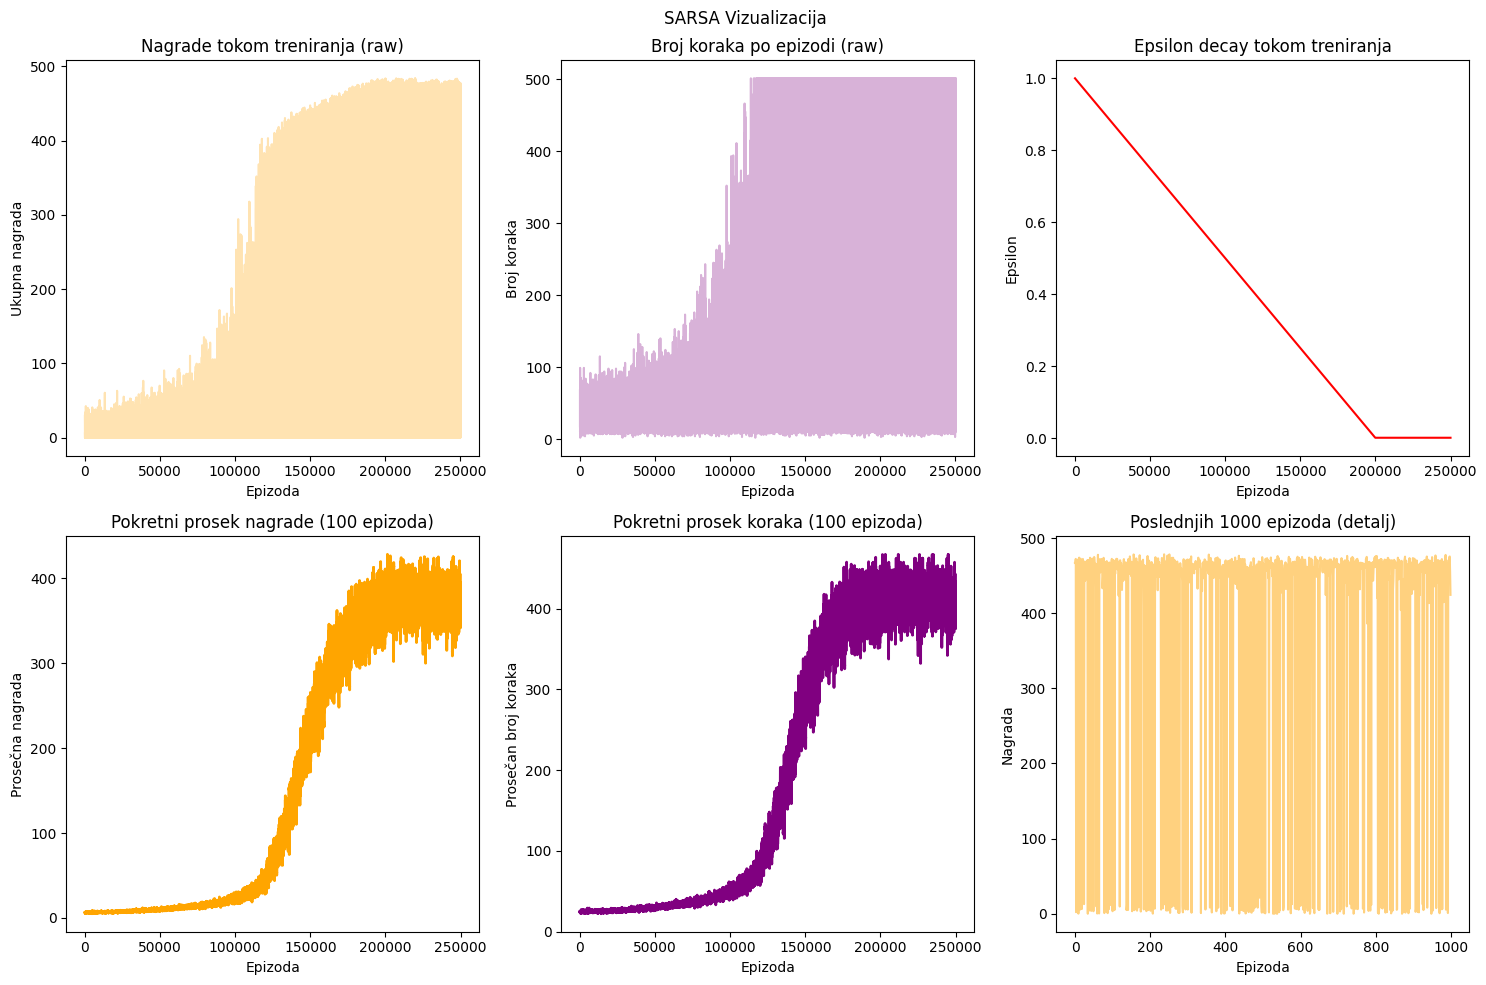

In [103]:
visualize_sarsa(rewards_per_episode_S, steps_per_episode_S, EPISODES_S, 1, eps_decay_rate_S, EPS_MIN_S)

### SARSA analiza grafika
Agent u početku intenzivno istražuje prostor stanja i akcija, što se vidi kroz niske i nestabilne nagrade. Kako treniranje napreduje, kriva nagrade poprima sigmoidni oblik – spor početak, zatim izražen rast i konačno stabilizacija. 

Broj koraka po epizodi prati rast nagrade. Kako se performanse poboljšavaju, agent uspeva da održava epizodu duže (veći broj koraka), što ukazuje na bolju kontrolu i stabilnije ponašanje. Stabilizacija broja koraka blizu maksimuma sugeriše da je agent konvergirao ka skoro optimalnoj politici u okviru diskretizovanog prostora stanja.

Primetan je značajan skok u učenju dok je epsilon bio u opsegu približno 0.6–0.2. U toj fazi agent je imao dobar balans između eksploracije i eksploatacije – dovoljno istraživanja da ispravi ranije procene, ali i dovoljno eksploatacije da konsoliduje naučenu politiku. Pošto SARSA koristi on-policy pristup, stabilnost učenja je izraženija jer se ažuriranje Q-vrednosti zasniva na akciji koja je zaista izabrana prema trenutnoj politici.

Linearni epsilon decay može biti relativno nagao, jer ravnomerno smanjuje eksploraciju tokom celog procesa treniranja. Eksponencijalni decay bi omogućio fleksibilniji prelaz – brže smanjenje eksploracije u ranoj fazi, ali sporije približavanje minimalnoj vrednosti, što može dodatno doprineti stabilnosti kod on-policy algoritama poput SARSA-e.

Pokretni prosek nagrade i broja koraka pokazuje glatke krive bez izraženih oscilacija. Učenje deluje stabilno i postepeno, što je u skladu sa karakteristikama SARSA algoritma, koji je često konzervativniji i manje sklon naglim promenama u odnosu na Q-learning.

U poslednjih 1000 epizoda većina epizoda ostvaruje rezultate blizu maksimuma (~450–480), ali su prisutni povremeni veliki padovi (~ 0). Ovi padovi su očekivani kod SARSA algoritma, jer on ažurira vrednosti u skladu sa ε-greedy politikom. To znači da čak i u kasnijoj fazi treniranja, povremene eksplorativne akcije mogu dovesti do suboptimalnih ishoda.

### Izvoz Q tabela upotrebom numpy biblioteke

In [104]:
np.save('./q-tables/Q_table.npy', Q)
np.save('./q-tables/Q_S_table.npy', Q_S)

## Zaključak

Uporedni pregled utreniranih agenata upotrebom Q-Learning i SARSA algoritma.

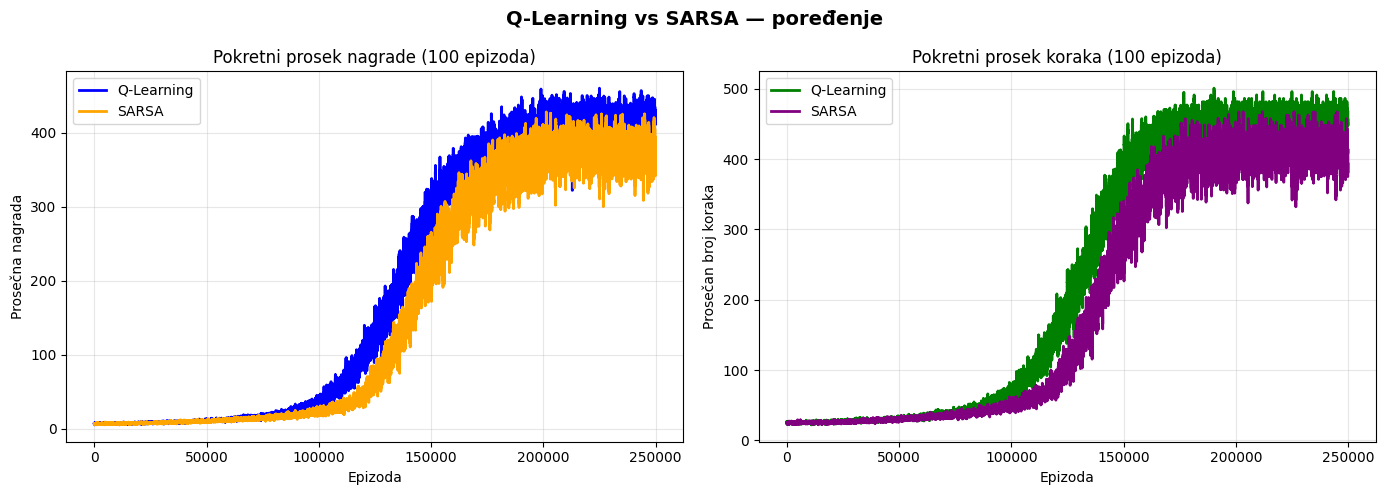

In [105]:
visualize_comparison(rewards_per_episode, rewards_per_episode_S, steps_per_episode, steps_per_episode_S)

### Komparativna analiza

Q-Learning pokazuje brži rast performansi i dostiže nešto viši plato u odnosu na SARSA. Kriva nagrade kod Q-Learning-a ranije počinje da raste i stabilizuje se na višim vrednostima (~440–460), dok SARSA konvergira nešto sporije i stabilizuje se na blago nižem nivou (~400–430).

Sličan obrazac se vidi i kod broja koraka po epizodi. Q-Learning u proseku postiže veći broj koraka, što ukazuje na agresivniju optimizaciju politike. SARSA napreduje postepenije i deluje konzervativnije, što je očekivano jer je on-policy algoritam i ažurira vrednosti u skladu sa stvarno izabranom akcijom.

Može se zaključiti da je Q-Learning efikasniji u pronalaženju gotovo optimalne politike u datom okruženju, dok je SARSA stabilnija, ali nešto opreznija u učenju.


### Šta bismo mogli unaprediti

Koristiti eksponencijalni decay umesto linearnog radi stabilnijeg prelaza ka eksploataciji.

Finija diskretizacija stanja radi smanjenja sporadičnih padova.

Testirati različite kombinacije hiperparametara (α, γ, ε) za oba algoritma radi objektivnijeg poređenja.